In [1]:
import os
import wfdb
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
PATH = "D:/skripsi_teknis/dataset/mitbih-afdb"

EDA

In [3]:
records = [f.replace(".hea", "") for f in os.listdir(PATH) if f.endswith(".hea")]
print("Total record:", len(records))

metadata_rows = []
all_rows = []

for rec in tqdm(records, desc="Reading records"):
    try:
        record = wfdb.rdrecord(os.path.join(PATH, rec))
        ann = wfdb.rdann(os.path.join(PATH, rec), "atr")

        fs = record.fs
        channels = ",".join(record.sig_name)

        labels = ann.aux_note
        times = ann.sample / fs
        seg_durations = Counter()

        for i in range(len(labels) - 1):
            label = labels[i].strip()
            seg_durations[label] += times[i+1] - times[i]

        for label, dur in seg_durations.items():
            all_rows.append({
                "record": rec,
                "fs": fs,
                "channels": channels,
                "duration_sec": record.sig_len / fs,
                "label": label,
                "label_duration_sec": dur
            })

        metadata_rows.append({
            "record": rec,
            "fs": fs,
            "channels": channels,
            "annotations": ",".join(sorted(set(labels)))
        })

    except Exception as e:
        print(f"⚠️ Error reading {rec}: {e}")

Total record: 23


Reading records:   0%|          | 0/23 [00:00<?, ?it/s]

Reading records: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


In [4]:
df = pd.DataFrame(all_rows)
df.to_csv("D:/skripsi_teknis/results/eda_summary.csv", index=False)

meta_df = pd.DataFrame(metadata_rows)
print("\n=== Metadata per Record ===")
display(meta_df)


=== Metadata per Record ===


,record,fs,channels,annotations
0,04015,250,"ECG1,ECG2","(AFIB,(N"
1,04043,250,"ECG1,ECG2","(AFIB,(AFL,(N"
2,04048,250,"ECG1,ECG2","(AFIB,(N"
3,04126,250,"ECG1,ECG2","(AFIB,(N"
4,04746,250,"ECG1,ECG2","(AFIB,(N"
5,04908,250,"ECG1,ECG2","(AFIB,(AFL,(N"
6,04936,250,"ECG1,ECG2","(AFIB,(AFL,(N"
7,05091,250,"ECG1,ECG2","(AFIB,(N"
8,05121,250,"ECG1,ECG2","(AFIB,(J,(N"
9,05261,250,"ECG1,ECG2","(AFIB,(N"


In [5]:
print("\n=== Ringkasan Durasi Dataset ===")
print("Total durasi dataset (jam):", round(df["duration_sec"].sum()/3600, 2))
print("Durasi rata-rata per record (jam):", round(df.groupby("record")["duration_sec"].first().mean()/3600, 2))


=== Ringkasan Durasi Dataset ===
Total durasi dataset (jam): 529.93
Durasi rata-rata per record (jam): 10.18



=== Distribusi Total Anotasi ===


label
(N       99.03
(AFIB    44.16
(AFL      0.69
(J        0.09
Name: label_duration_sec, dtype: float64

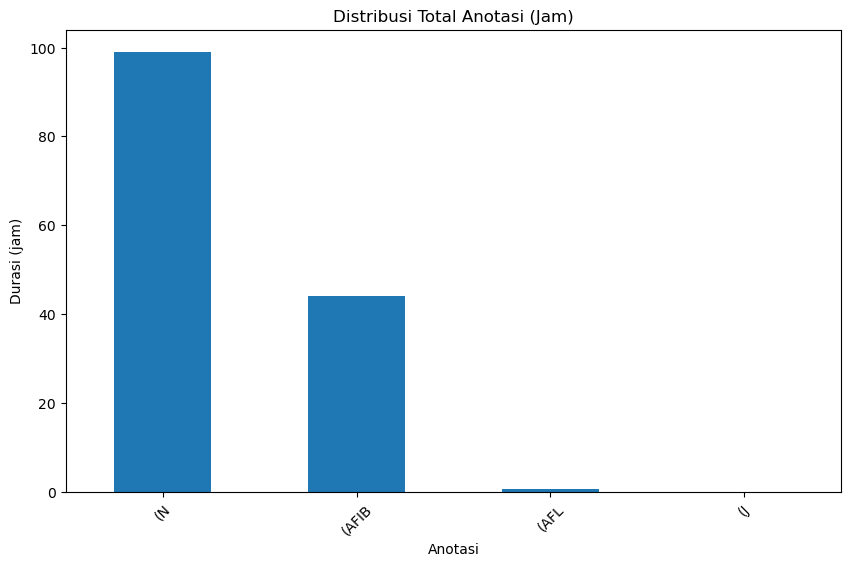

In [6]:
print("\n=== Distribusi Total Anotasi ===")
label_dist = df.groupby("label")["label_duration_sec"].sum().sort_values(ascending=False)
label_dist_hours = label_dist / 3600
display(label_dist_hours.round(2))

plt.figure(figsize=(10,6))
label_dist_hours.plot(kind="bar")
plt.title("Distribusi Total Anotasi (Jam)")
plt.ylabel("Durasi (jam)")
plt.xlabel("Anotasi")
plt.xticks(rotation=45)
plt.show()


=== Distribusi Anotasi per Record ===


label,(AFIB,(AFL,(J,(N
record,,,,
04015,0.065899,0.000000,0.000000,1.556752
04043,2.199918,0.003583,0.000000,7.775630
04048,0.100216,0.000000,0.000000,8.439846
04126,0.382770,0.000000,0.000000,8.853991
04746,5.431391,0.000000,0.000000,2.898408
04908,0.856237,0.070449,0.000000,8.848612
04936,7.377971,0.000000,0.000000,1.908683
05091,0.024102,0.000000,0.000000,4.821351
05121,6.446929,0.000000,0.063814,2.288218


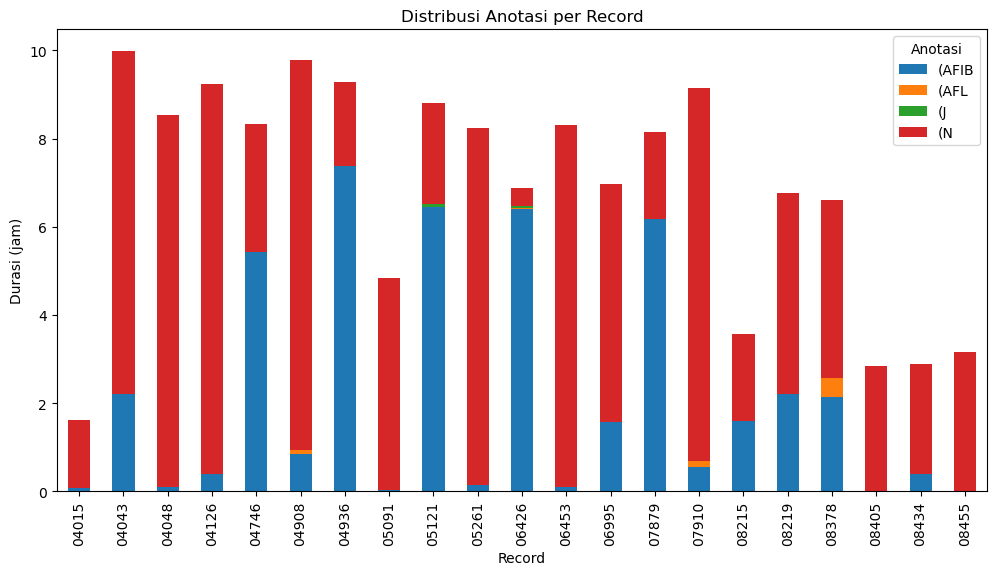

In [7]:
pivot_hours = df.pivot_table(
    index="record",
    columns="label",
    values="label_duration_sec",
    aggfunc="sum",
    fill_value=0
) / 3600

print("\n=== Distribusi Anotasi per Record ===")
display(pivot_hours)

pivot_hours.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Distribusi Anotasi per Record")
plt.ylabel("Durasi (jam)")
plt.xlabel("Record")
plt.legend(title="Anotasi")
plt.show()

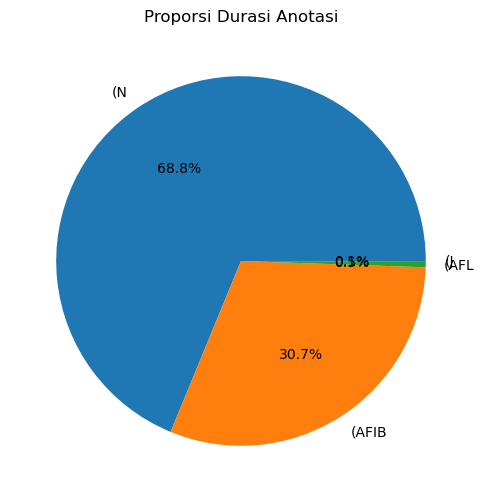

In [8]:
plt.figure(figsize=(6,6))
label_dist_hours.plot(kind="pie", autopct="%1.1f%%")
plt.title("Proporsi Durasi Anotasi")
plt.ylabel("")
plt.show()